
Sphere: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.1 MB/s 
     |████████████████████████████████| 872 kB 47.8 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=7395d71e2866149bbed7d2c99b97953e2b213edcb14b50381e75d444fdefe098
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=3467a926ea7a0f54fda80355953120ab08cd7361cbf50ad532cc1555277c03e9
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Sphere'
n_test = 500
eps = 1e-08

util = 'CBM'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Sphere(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * ( x1_training ** 2
                            + x2_training ** 2
                            )
        
# Constraints:
lb = -5.12
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))


In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [8]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = dim

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]
    
    def CBM(self, y_global_orig, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, y_global_orig, mean, std, ds, dm):
    
        return self.f(y_global_orig, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.x_best_std)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.x_best_std_exact = np.std(x_best_exact)
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        x_best_std = str(self.x_best_std)
        x_best_std_exact = str(self.x_best_std_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_exact = BOLD + OKGREEN + x_best_std_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std_exact, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.x_best_std_approx = np.std(x_best_approx)
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        x_best_std = str(self.x_best_std)
        x_best_std_approx = str(self.x_best_std_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_approx = BOLD + OKGREEN + x_best_std_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1663239231.3157241

In [13]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    	    
1  	 [ 4.04077223 -4.24914728]	 34.383092818836786	 1.275455677703416	 3.691785971903543	 4.210350150347429
2  	 [4.5988851 5.12     ]	 47.36414416975239	 1.275455677703416	 3.203911494720302	 3.5519473993112305
3  	 [-5.12  5.12]	 52.4288	 1.275455677703416	 3.336983928256136	 3.858661566198433
4  	 [5.12       0.34960602]	 26.33662436715262	 1.275455677703416	 3.5966569341686987	 3.6281886384274196
5  	 [ 0.66573509 -2.04884232]	 4.640958055089854	 1.275455677703416	 2.7245929

In [14]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    	    
1  	 [4.81874241 3.07464552]	 32.673723450709105	 0.6972563370202991	 3.7392471818164985	 3.803265468944183
2  	 [ 5.12       -4.88716149]	 50.09874746146686	 0.6972563370202991	 3.059133412075313	 3.969792722960523
3  	 [-0.00756968  5.12      ]	 26.214457300112368	 0.6972563370202991	 3.544780390813184	 3.808979970221521
4  	 [-5.12  5.12]	 52.4288	 0.6972563370202991	 3.508404587947239	 3.6184250168505763
5  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 3.99416827448979	 

In [15]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    	    
1  	 [ 4.62620661 -1.72679436]	 24.38360633802604	 4.59675431006429	 2.215013408667592	 3.5171310798317847
2  	 [-4.45081374  5.12      ]	 46.02414292291322	 4.59675431006429	 2.8365036797514	 4.058360810581519
3  	 [ 0.82902811 -5.12      ]	 26.901687613919048	 4.59675431006429	 3.199158923462809	 3.4974170760526233
4  	 [-0.32997453  5.12      ]	 26.323283189989358	 4.59675431006429	 3.065409022560519	 2.9432161304785622
5	 [ 0.82867679 -1.27970313]	 2.324345319775305	 2.324345319775305	

In [16]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=opt)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    	    
1  	 [-5.12        4.13896292]	 43.345414074890286	 6.844040613967918	 2.9144395930511804	 3.9081554543960904
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 3.7903581136872613	 4.199794314463703
3  	 [0.30990389 5.12      ]	 26.310440419430538	 6.844040613967918	 3.27561430614555	 3.641025597434746
4  	 [-0.95720958 -5.12      ]	 27.13065018759924	 6.844040613967918	 3.2225781931339115	 3.1589772281928346
5	 [0.70233408 1.02862293]	 1.5513383070776192	 1.5513383070776192	 3.1086169003

In [17]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 4.461640564215958	 4.5162802315012724
2  	 [5.12 5.12]	 52.4288	 1.3234068721819314	 4.391281755178421	 3.8702485725789155
3  	 [-5.12       -0.04786262]	 26.216690830110842	 1.3234068721819314	 3.4846160222615885	 3.7682679141532147
4  	 [0.96168922 5.12      ]	 27.139246154188132	 1.3234068721819314	 3.4659666235692446	 3.403111477980042
5  	 [-5.12 -5.12]	 52.4288	 1.3234068721819314	 3.30281609435928

In [18]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    	    
1  	 [2.60017104 5.12      ]	 32.975289420104396	 0.7844720799352826	 4.036164788475474	 3.818096236562348
2  	 [-5.12       -4.58808044]	 47.26488208477529	 0.7844720799352826	 3.822748992279807	 3.7228720759576994
3  	 [-5.12  5.12]	 52.4288	 0.7844720799352826	 3.4369903913606836	 3.6518337176588265
4  	 [-0.87293392 -4.16934755]	 18.1454726334986	 0.7844720799352826	 3.3122512521775977	 3.326448555419518
5  	 [5.12       2.02293344]	 30.30665972131474	 0.784472079935282

In [19]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    	    
1  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 2.868484661406735	 3.2175181065107923
2  	 [ 5.12 -5.12]	 52.4288	 5.622519010932044	 3.7611921575874034	 3.746379589748004
3  	 [3.33004618 5.12      ]	 37.30360754787367	 5.622519010932044	 3.801170643170861	 3.5227089156304867
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 2.8894091467469694	 3.046307140328312
5	 [ 1.22347344 -0.77273501]	 2.094006650627022	 2.094006650627022	 3.1885882983186855	 3.1

In [20]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    	    
1  	 [-0.07607243  2.20183427]	 4.853861179069208	 0.10287109474532606	 3.0250315318051917	 3.7897315966540193
2  	 [ 5.12 -5.12]	 52.4288	 0.10287109474532606	 3.3605606456210233	 4.199805511354719
3  	 [-4.61584642  5.12      ]	 47.52043815253764	 0.10287109474532606	 2.800038456751072	 3.515214329893685
4  	 [-5.12      -0.2129158]	 26.25973313957643	 0.10287109474532606	 3.2298891845518387	 3.432808037725922
5  	 [ 1.22698383 -3.60609281]	 14.509394669677787	 0.10287

In [21]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    	    
1  	 [3.69491889 4.82146316]	 36.89893267190826	 7.349882113053805	 2.9784999898365063	 3.032243567761824
2  	 [-2.28574161  5.12      ]	 31.43901470320111	 7.349882113053805	 3.40788216900173	 4.124920513044523
3  	 [ 4.86862469 -0.97259356]	 24.649444608191978	 7.349882113053805	 3.1907313451108346	 3.50599529535483
4	 [0.53970267 1.34076621]	 2.088932992660779	 2.088932992660779	 3.0547336453824574	 3.5783348109604463
5  	 [ 4.23301191 -5.12      ]	 44.132789832665836	 2.0889

In [22]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928501	    	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928501	    	    
init	 [-0.01528819 -2.81808235]	 7.941821858928501	 7.941821858928501	    	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928501	    	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928501	    	    
1  	 [ 5.12       -0.36550721]	 26.347995520869706	 7.941821858928501	 3.47683395514817	 3.4016687789658735
2  	 [5.12 5.12]	 52.4288	 7.941821858928501	 2.971245135127575	 3.1152588863290793
3  	 [-5.12       -0.59619261]	 26.569845626551412	 7.941821858928501	 2.6464990514811295	 3.2812283968944174
4  	 [-0.58335554  5.12      ]	 26.554703691363564	 7.941821858928501	 3.516214653471013	 3.475431062807869
5  	 [-5.12  5.12]	 52.4288	 7.941821858928501	 3.338564242010751	 3.403886705

In [23]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 3.3075201942963486	 3.9465008881109287
2  	 [-5.12  5.12]	 52.4288	 0.6899456214148796	 2.6325333916114477	 3.5019931319669944
3  	 [ 5.12       -0.71940624]	 26.731945333526454	 0.6899456214148796	 3.260652369843474	 3.362874848331494
4  	 [0.92504221 5.12      ]	 27.070103093759652	 0.6899456214148796	 2.542967950764835	 2.4028411793281035
5  	 [-0.19914441 -2.48361726]	 6.2080131906150955	 0.689945621414

In [24]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    	    
1  	 [5.12 5.12]	 52.4288	 5.993464196233534	 3.9259317917913807	 3.769262607483161
2  	 [-5.12 -5.12]	 52.4288	 5.993464196233534	 3.5575374340024064	 3.233169577106097
3	 [2.28109108 0.77883167]	 5.809955277797381	 5.809955277797381	 2.836259385400842	 2.773248456464121
4  	 [0.22738663 5.12      ]	 26.26610468015496	 5.809955277797381	 2.939769492267899	 3.106941953316595
5  	 [-0.48979339 -3.66845669]	 13.697472042083964	 5.809955277797381	 2.8884453174320557	 2.567071988395611

In [25]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    	    
1  	 [-4.10876704 -2.60547476]	 23.670465283396044	 7.271500601275535	 2.770317080339137	 3.1094977193260593
2  	 [-5.12  5.12]	 52.4288	 7.271500601275535	 3.6630280566058726	 3.675853659950238
3  	 [-0.59460557 -5.12      ]	 26.56795578299085	 7.271500601275535	 3.4551915379173566	 3.1059779149241207
4  	 [-2.6637204   1.37398066]	 8.98322925524812	 7.271500601275535	 3.0953239145825195	 3.04036888689647
5  	 [ 5.12 -5.12]	 52.4288	 7.271500601275535	 3.455850873263659	 3.939405921995

In [26]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    	    
1  	 [-5.05057017 -1.15674792]	 26.84632475762311	 3.480496204392171	 3.9627000432958677	 3.889387374310076
2  	 [5.10672577 5.12      ]	 52.29304813571929	 3.480496204392171	 3.814918691994709	 3.6221385684734466
3  	 [ 5.12       -0.07516403]	 26.220049631965622	 3.480496204392171	 2.9198416564403677	 3.212926440582003
4  	 [-3.19710519 -5.12      ]	 36.43588159203407	 3.480496204392171	 2.7390905684360605	 3.134845063102557
5	 [-1.75117779  0.23577509]	 3.122213540862005	 3.1222

In [27]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    	    
1  	 [2.7754098  2.98802689]	 16.631204280641075	 5.383887924980681	 3.835248702533781	 3.7471618644492906
2  	 [-5.12       4.9245729]	 50.46581827179171	 5.383887924980681	 3.1152043809272696	 3.677762936930484
3  	 [-0.71672187  5.12      ]	 26.728090234593502	 5.383887924980681	 3.9083882443005993	 3.8141200233022894
4  	 [-0.11957232 -5.12      ]	 26.228697539157473	 5.383887924980681	 3.0090317859064006	 2.924081027639689
5  	 [5.12       0.18687093]	 26.24932074312874	 5.3

In [28]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    	    
1  	 [2.2651866 5.12     ]	 31.345470322053288	 8.084978900492077	 3.826570898006818	 3.922062868327192
2  	 [5.12       0.61270613]	 26.58980880569518	 8.084978900492077	 3.479085810942014	 3.2772858037401433
3  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 3.5462103173001607	 3.8082650422202167
4	 [0.93917899 0.95035012]	 1.7852225112602405	 1.7852225112602405	 2.794147837538308	 3.0665142536610337
5  	 [ 5.12 -5.12]	 52.4288	 1.7852225112602405	 2.983586471555195	 3.24494375630

In [29]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 3.1994548844576527	 4.450626685862143
2  	 [-3.74909815  5.12      ]	 40.2701369582173	 2.5824114132885994	 3.1500683088109938	 3.3687244221994854
3  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 3.4631119631347342	 3.36251768140345
4  	 [0.61519743 5.12      ]	 26.592867874994994	 2.5824114132885994	 3.5252996202275315	 3.784390665774973
5  	 [ 0.85278936 -2.81548154]	 8.65418597667288	 2.5824114132885994	 2.

In [30]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    	    
1  	 [-5.00718904  2.9174042 ]	 33.58318939621877	 2.3742017032787373	 3.0184732290730483	 3.7135233877559344
2  	 [-5.12       -1.45226112]	 28.32346236598542	 2.3742017032787373	 3.168242883437177	 3.065445087320609
3  	 [-1.55294272  0.80609186]	 3.061415178523301	 2.3742017032787373	 3.8418911610676623	 3.270216261433105
4  	 [-2.01803779  5.12      ]	 30.286876519444945	 2.3742017032787373	 3.63925556520413	 3.5883615582869077
5  	 [ 0.15333067 -2.3835037 ]	 5.704600171057

In [31]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    	    
1  	 [ 4.75301553 -5.12      ]	 48.805556653491244	 12.957869519084127	 3.392851680753163	 4.65283246792334
2	 [ 1.50915116 -1.41210432]	 4.271575848279678	 4.271575848279678	 3.354642608563725	 3.367036098068793
3  	 [5.12 5.12]	 52.4288	 4.271575848279678	 4.022898689865994	 3.8286261954330514
4  	 [-5.12       -1.05767361]	 27.333073470281633	 4.271575848279678	 2.829824675396934	 3.131661947827292
5  	 [-1.2576106  5.12     ]	 27.79598442958272	 4.271575848279678	 2.891807

In [32]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    	    
1  	 [-3.7715933  -4.66916893]	 36.02605452946127	 1.579257056101869	 3.427626503925378	 3.269252587931521
2  	 [ 5.12 -5.12]	 52.4288	 1.579257056101869	 2.861980520228427	 3.6267550088564637
3  	 [ 5.12       -0.75178267]	 26.779577180703768	 1.579257056101869	 2.903416134234634	 2.9106682153634598
4  	 [-2.73894408  5.12      ]	 33.71621469401172	 1.579257056101869	 3.093833465677091	 3.573537958910844
5  	 [1.47319363 0.3917278 ]	 2.323750146559797	 1.579257056101869	 3.2612440883

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1663240084.7917163

In [34]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    	    
1  	 [ 4.04077223 -4.24914728]	 34.383092818836786	 1.275455677703416	 3.691785971903543	 4.210350150347429
2  	 [5.09038263 4.7298859 ]	 48.28381601639272	 1.275455677703416	 3.203911494720302	 3.5519473993112305
3  	 [3.00335905 0.42811141]	 9.203444954634248	 1.275455677703416	 3.333347591924856	 3.838709013770147
4  	 [-4.89967556  4.5871254 ]	 45.04853999879627	 1.275455677703416	 3.730459237769259	 4.306288549276068
5  	 [0.96939003 5.12      ]	 27.154117031593465	 1.27545

In [35]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    	    
1  	 [4.81874241 3.07464552]	 32.673723450709105	 0.6972563370202991	 3.7392471818164985	 3.803265468944183
2  	 [ 4.84261962 -3.9651574 ]	 39.17343798926941	 0.6972563370202991	 3.059133412075313	 3.969792722960523
3  	 [1.81916914e-03 5.12000000e+00]	 26.21440330937637	 0.6972563370202991	 3.641573247019779	 3.8545554488340668
4  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 3.3871924672206783	 3.4876343506627427
5  	 [ 3.35003283 -0.51212335]	 11.484990311875338	 0.697256

In [36]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    	    
1  	 [ 1.83377975 -2.95605019]	 12.100980895049556	 4.59675431006429	 2.215013408667592	 3.5171310798317847
2  	 [-3.33183818  5.05236168]	 36.62750426873441	 4.59675431006429	 3.229835850000944	 4.186453035322514
3  	 [ 5.12       -0.35003239]	 26.336922676042715	 4.59675431006429	 3.2316887560462964	 3.3056285772606913
4  	 [-1.03201102 -5.12      ]	 27.279446738975928	 4.59675431006429	 3.174444703829873	 2.892666624366455
5	 [ 1.69181282 -0.01788526]	 2.8625505026639892	 2.862550502663

In [37]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    	    
1  	 [-1.14361995  4.64615781]	 22.89464894080344	 6.844040613967918	 2.9144395930511804	 3.9081554543960904
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 3.9273347184536607	 3.421996763016359
3  	 [-0.97092589 -5.12      ]	 27.15709707632272	 6.844040613967918	 3.3006712722065794	 3.691598736015993
4	 [0.65713872 1.17930062]	 1.822581246462247	 1.822581246462247	 2.942250668320863	 3.312802730219831
5  	 [-5.12       2.7052626]	 33.53284574993995	 1.822581246462247	 2.81680786038347

In [38]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 4.461640564215958	 4.5162802315012724
2  	 [5.12 5.12]	 52.4288	 1.3234068721819314	 4.391281755178421	 3.8702485725789155
3  	 [-5.12      -0.2720871]	 26.288431390445176	 1.3234068721819314	 3.4846160222615885	 3.7682679141532147
4  	 [1.0359417  4.73281627]	 23.472725051060333	 1.3234068721819314	 3.4979771917049467	 3.403779401627839
5  	 [-5.12 -5.12]	 52.4288	 1.3234068721819314	 3.4220347924289576

In [39]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    	    
1  	 [5.12 5.12]	 52.4288	 0.7844720799352826	 4.036164788475474	 3.818096236562348
2  	 [-5.12 -5.12]	 52.4288	 0.7844720799352826	 3.734459716347911	 3.6319953041675106
3  	 [0.09006709 5.12      ]	 26.22251208042997	 0.7844720799352826	 3.070248757511774	 3.2901867048373976
4  	 [-0.87300913 -4.37691554]	 19.919534623969444	 0.7844720799352826	 3.158561220486378	 3.940848801661554
5  	 [1.59347471 1.91404708]	 6.202737861784824	 0.7844720799352826	 2.3273509708966897	 3.

In [40]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    	    
1  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 2.868484661406735	 3.2175181065107923
2  	 [3.33153055 5.12      ]	 37.313495812505	 5.622519010932044	 3.7611921575874034	 3.746379589748004
3  	 [ 4.52357055 -4.16736482]	 37.8296200448288	 5.622519010932044	 3.511749026108728	 3.821955454411549
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 2.8894091467469694	 3.046307140328312
5	 [ 1.20810674 -0.75569857]	 2.030602231941464	 2.030602231941464	 3.323

In [41]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    	    
1  	 [-0.10522724  2.15793299]	 4.667747547858372	 0.10287109474532606	 3.0250315318051917	 3.7897315966540193
2  	 [ 2.80805062 -4.94324048]	 32.320774667618174	 0.10287109474532606	 3.3604065854973353	 4.20954711774455
3  	 [-5.12        0.67964193]	 26.67631315818064	 0.10287109474532606	 2.917863327887236	 3.541630650113821
4  	 [-1.66085899  5.12      ]	 28.97285256988505	 0.10287109474532606	 3.3761551431474373	 3.947902559180855
5  	 [ 1.40982162 -1.88822   ]	 5.5

In [42]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    	    
1  	 [5.12 5.12]	 52.4288	 7.349882113053805	 2.9784999898365063	 3.032243567761824
2  	 [-0.67683284  4.157138  ]	 17.739899051817385	 7.349882113053805	 3.3354499838101637	 3.588536234038563
3  	 [ 5.12       -1.53415824]	 28.56804150750456	 7.349882113053805	 3.049893890377064	 3.7881140062624485
4	 [1.23335774 0.72932725]	 2.0530895479974305	 2.0530895479974305	 3.0751198047528283	 3.5662661918809495
5  	 [3.80051028 1.69397977]	 17.31344586814809	 2.0530895479974305	 3.4305

In [43]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928501	    	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928501	    	    
init	 [-0.01528819 -2.81808235]	 7.941821858928501	 7.941821858928501	    	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928501	    	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928501	    	    
1  	 [ 5.12       -0.27137041]	 26.288041898087062	 7.941821858928501	 3.47683395514817	 3.4016687789658735
2  	 [5.12 5.12]	 52.4288	 7.941821858928501	 2.9517167839825103	 3.192202721862711
3  	 [-4.2170615  -0.72751033]	 18.312878996259908	 7.941821858928501	 2.649820220993946	 3.362962180448652
4  	 [0.74567789 5.12      ]	 26.770435510049882	 7.941821858928501	 3.6836015273148184	 3.3901242828644462
5	 [ 0.09924042 -0.03856958]	 0.011336272623869258	 0.011336272623869258	 3.0824

In [44]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 3.3075201942963486	 3.9465008881109287
2  	 [ 4.72023378 -0.58668015]	 22.62480054231176	 0.6899456214148796	 2.6325333916114477	 3.5019931319669944
3  	 [-0.2494569  -2.42522162]	 5.943928660055336	 0.6899456214148796	 3.5669025282017026	 4.189042391764775
4  	 [1.48958714 0.26457168]	 2.288868026551726	 0.6899456214148796	 2.706669410222892	 3.444740294765445
5  	 [-3.32376873  3.3331484 ]	 22.15731682745

In [45]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    	    
1  	 [5.12 5.12]	 52.4288	 5.993464196233534	 3.9259317917913807	 3.769262607483161
2  	 [-5.12 -5.12]	 52.4288	 5.993464196233534	 3.5575374340024064	 3.233169577106097
3	 [2.24183838 0.82371079]	 5.704338807646411	 5.704338807646411	 2.836259385400842	 2.773248456464121
4  	 [-0.45836603 -4.41534615]	 19.705381038420658	 5.704338807646411	 2.9261050172843963	 3.106985200628437
5  	 [0.67165118 4.31105957]	 19.03634991003064	 5.704338807646411	 2.924611951959464	 3.178222228540475

In [46]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    	    
1  	 [-5.12       -4.49089954]	 46.382578643535034	 7.271500601275535	 2.770317080339137	 3.1094977193260593
2  	 [-4.28216005  2.18552227]	 23.11340233342493	 7.271500601275535	 2.825919674114535	 4.169763739009419
3	 [-1.65780332 -1.18801059]	 4.159680992672419	 4.159680992672419	 2.812324772024518	 3.1473510280146284
4  	 [-1.68752669  5.12      ]	 29.06214631283505	 4.159680992672419	 2.9443068079686086	 3.7200131268611956
5  	 [-0.60335518 -5.12      ]	 26.57843747498599	 4.1596809

In [47]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    	    
1  	 [-5.12       -0.20573052]	 26.256725047249272	 3.480496204392171	 3.9627000432958677	 3.889387374310076
2  	 [5.12 5.12]	 52.4288	 3.480496204392171	 4.086936464341358	 3.8468234187866703
3  	 [-4.14991067 -5.12      ]	 43.43615857355198	 3.480496204392171	 2.7975791437331203	 3.2514452677636627
4  	 [ 4.91780919 -0.01884161]	 24.185202214686477	 3.480496204392171	 2.859702992538294	 3.224475095637311
5	 [-1.73528793  0.36105645]	 3.14158594706688	 3.14158594706688	 2.65569599

In [48]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    	    
1  	 [5.12       4.52980016]	 46.733489444894914	 5.383887924980681	 3.835248702533781	 3.7471618644492906
2  	 [-0.5478704  5.12     ]	 26.51456197423583	 5.383887924980681	 2.6859249016515943	 3.4315431058548276
3  	 [-5.12        3.56609153]	 38.931408770036384	 5.383887924980681	 3.0566283542517474	 3.532918308183908
4  	 [2.52610034 0.80301001]	 7.026008011791001	 5.383887924980681	 2.7210176998352837	 2.7059859406326345
5  	 [-1.01051201 -5.12      ]	 27.23553452965658	 5.3

In [49]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    	    
1  	 [3.07523458 5.12      ]	 35.67146771295724	 8.084978900492077	 3.826570898006818	 3.922062868327192
2  	 [5.12       0.36360257]	 26.34660682702725	 8.084978900492077	 3.673768685896399	 3.3409480646890555
3  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 3.472767146377818	 3.674184777425383
4	 [0.87301974 1.36264836]	 2.6189740179195704	 2.6189740179195704	 2.7384164062077527	 3.3106661445546934
5  	 [-0.37060264  3.54875585]	 12.731014390572904	 2.6189740179195704	 2.7719033

In [50]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 3.1994548844576527	 4.450626685862143
2  	 [-1.21860665  5.12      ]	 27.69940216230365	 2.5824114132885994	 3.1500683088109938	 3.3687244221994854
3  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 3.402117583300204	 3.4232607819470626
4  	 [ 0.90859396 -3.03909191]	 10.061622616517566	 2.5824114132885994	 3.538445314018484	 3.8344214855659833
5  	 [ 5.12       -0.69476328]	 26.69709601607087	 2.582411413288599

In [51]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    	    
1  	 [-5.00718904  2.9174042 ]	 33.58318939621877	 2.3742017032787373	 3.0184732290730483	 3.7135233877559344
2  	 [-2.20629523 -0.4515276 ]	 5.07161579635752	 2.3742017032787373	 3.168242883437177	 3.065445087320609
3  	 [-1.33222855  2.98567876]	 10.68911060027898	 2.3742017032787373	 3.787453396625627	 3.256818157417347
4  	 [-5.12       -1.93527137]	 29.959675294794472	 2.3742017032787373	 3.389899678001269	 3.5059129194987264
5  	 [ 0.90377736 -5.06841274]	 26.505621238983

In [52]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    	    
1  	 [ 4.31277115 -4.24489917]	 36.61916391891194	 12.957869519084127	 3.392851680753163	 4.65283246792334
2	 [-0.64703261 -0.05256687]	 0.42141447497566265	 0.42141447497566265	 3.549484880024515	 3.663416758991657
3  	 [5.12 5.12]	 52.4288	 0.42141447497566265	 4.011474873888966	 3.8799921464470235
4  	 [-5.12       -1.18838053]	 27.626648283050066	 0.42141447497566265	 2.9589530562409005	 3.2258602726535544
5  	 [ 1.50132809 -0.80717035]	 2.9055100065315305	 0.4214144749756

In [53]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    	    
1  	 [-5.12 -5.12]	 52.4288	 1.579257056101869	 3.427626503925378	 3.269252587931521
2  	 [ 5.12       -1.04604676]	 27.30861383418941	 1.579257056101869	 3.1099770567750276	 3.6486511145617317
3  	 [-2.70544907 -2.08828803]	 11.680401570842946	 1.579257056101869	 2.796150732451176	 3.113827609578339
4  	 [-1.10837321 -5.12      ]	 27.442891171638696	 1.579257056101869	 3.0915674817855603	 3.204097253257676
5  	 [-2.72224889  5.12      ]	 33.62503902023204	 1.579257056101869	 2.846919

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


795.3775949478149

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-4.291431036079864, -4.208645985374523)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-3.773218432769123, -4.098018410646908)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-4.5701587673857915, -3.638729076494572)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(-2.438907758177992, -3.7800601414116466)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(-3.8426445579060373, -5.076003439973669)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-7.871700194823921, -4.876525975321586)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(-3.939222560833622, -3.5999104038869305)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(-7.186826716691583, -4.091853575166087)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(-3.947826473002925, -3.119856434574241)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(-5.592509752863984, -4.479747727494332)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(-3.6506529446777334, -6.886709125434023)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-5.722189159934916, -4.589778639641301)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(-4.906762102202577, -7.3257180269914555)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-5.2735681059152935, -5.911920289354416)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(-4.607999838876927, -6.259077585239447)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(-2.4931385961293597, -2.526647507166379)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(-3.7878688174878175, -6.638711245637327)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(-5.406562873940401, -3.333616886139725)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-5.262529692459747, -2.5542878946862406)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(-6.7546264261236395, -3.285592605076735)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

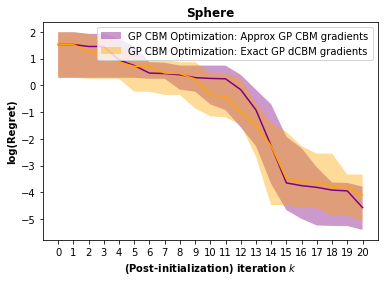

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Purple')
plt.plot(median_exact, color = 'Orange')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='GP CBM Optimization: Approx GP CBM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='GP CBM Optimization: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(853.4758405685425, 795.3775949478149)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history)
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

e1 = np.std(acqFuncExact_exact_1)
a1 = np.std(acqFuncApprox_exact_1)

e1, a1


(0.3293452870100626, 0.7288084400994019)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history)
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

e2 = np.std(acqFuncExact_exact_2)
a2 = np.std(acqFuncApprox_exact_2)

e2, a2


(0.384144191440326, 0.5512751289012123)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history)
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

e3 = np.std(acqFuncExact_exact_3)
a3 = np.std(acqFuncApprox_exact_3)

e3, a3


(0.38148036510399846, 0.5540488744030654)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history)
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

e4 = np.std(acqFuncExact_exact_4)
a4 = np.std(acqFuncApprox_exact_4)

e4, a4


(0.3822984948747756, 0.44694507770638897)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history)
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

e5 = np.std(acqFuncExact_exact_5)
a5 = np.std(acqFuncApprox_exact_5)

e5, a5


(0.6920286152745194, 0.6684393922823945)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history)
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

e6 = np.std(acqFuncExact_exact_6)
a6 = np.std(acqFuncApprox_exact_6)

e6, a6


(0.3993531967871338, 0.4357441798893502)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history)
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

e7 = np.std(acqFuncExact_exact_7)
a7 = np.std(acqFuncApprox_exact_7)

e7, a7


(0.3726400271503941, 0.38397416328402323)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history)
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

e8 = np.std(acqFuncExact_exact_8)
a8 = np.std(acqFuncApprox_exact_8)

e8, a8


(0.25566409545410895, 0.6775951911921698)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history)
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

e9 = np.std(acqFuncExact_exact_9)
a9 = np.std(acqFuncApprox_exact_9)

e9, a9


(0.38633894451638245, 0.45107206916888276)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history)
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

e10 = np.std(acqFuncExact_exact_10)
a10 = np.std(acqFuncApprox_exact_10)

e10, a10


(0.2737108252473809, 0.3973845420588127)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history)
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

e11 = np.std(acqFuncExact_exact_11)
a11 = np.std(acqFuncApprox_exact_11)

e11, a11


(0.2930496663867781, 0.5134404624888798)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history)
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

e12 = np.std(acqFuncExact_exact_12)
a12 = np.std(acqFuncApprox_exact_12)

e12, a12


(0.3974241008787982, 0.36874758765025145)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history)
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

e13 = np.std(acqFuncExact_exact_13)
a13 = np.std(acqFuncApprox_exact_13)

e13, a13


(0.2922430429880168, 0.4681484212579742)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history)
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

e14 = np.std(acqFuncExact_exact_14)
a14 = np.std(acqFuncApprox_exact_14)

e14, a14


(0.47046657422176763, 0.46460496289405145)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history)
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

e15 = np.std(acqFuncExact_exact_15)
a15 = np.std(acqFuncApprox_exact_15)

e15, a15


(0.4884271912301322, 0.3959355068134309)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history)
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

e16 = np.std(acqFuncExact_exact_16)
a16 = np.std(acqFuncApprox_exact_16)

e16, a16


(0.4019364738913468, 0.4659911378956434)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history)
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

e17 = np.std(acqFuncExact_exact_17)
a17 = np.std(acqFuncApprox_exact_17)

e17, a17


(0.3445287206720722, 0.5343132591526011)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history)
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

e18 = np.std(acqFuncExact_exact_18)
a18 = np.std(acqFuncApprox_exact_18)

e18, a18


(0.4680204139115348, 0.3955206174841543)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history)
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

e19 = np.std(acqFuncExact_exact_19)
a19 = np.std(acqFuncApprox_exact_19)

e19, a19


(0.5368929122006694, 0.5839140560615919)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history)
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

e20 = np.std(acqFuncExact_exact_20)
a20 = np.std(acqFuncApprox_exact_20)

e20, a20


(0.35373506633908813, 0.4729911116588298)

In [120]:
### Summarize arrays: 

exact_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
approx_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.std(exact_stddev), np.std(approx_stddev)


(0.09819972365500014, 0.10064447522167679)

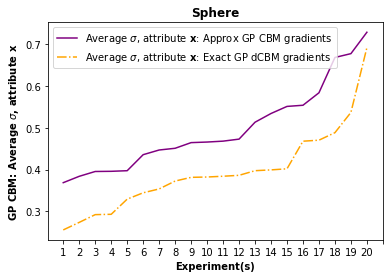

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(approx_stddev, color = 'Purple', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Approx GP CBM gradients')
plt.plot(exact_stddev, color = 'Orange', ls='-.', label='Average $\sigma$, attribute $\mathbf{x}$: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold')
plt.ylabel('GP CBM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualize!
